[ 0.01        0.05623413  0.31622776  1.7782794  10.        ]
RUN: std=0.009999999776482582, total 1/5 steps
Converged in 2 iterations
Converged in 2 iterations
Converged in 2 iterations
RUN: std=0.05623413249850273, total 2/5 steps
Converged in 2 iterations
Converged in 2 iterations
Converged in 2 iterations
RUN: std=0.3162277638912201, total 3/5 steps
Converged in 7 iterations
Converged in 6 iterations
Converged in 9 iterations
RUN: std=1.778279423713684, total 4/5 steps
Converged in 234 iterations
Converged in 92 iterations
Converged in 71 iterations
RUN: std=10.0, total 5/5 steps
Converged in 160 iterations
Converged in 120 iterations
Converged in 181 iterations
(5, 6, 2)


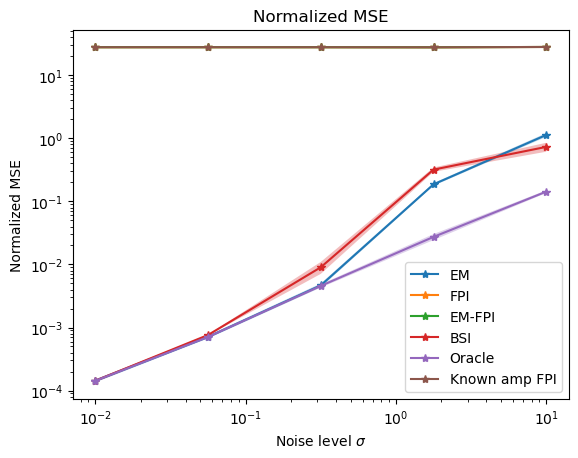

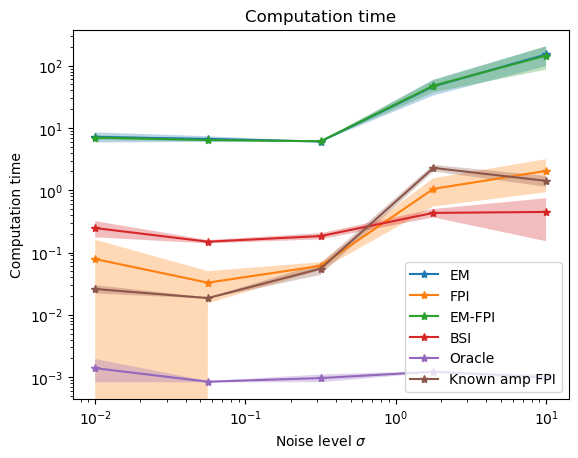

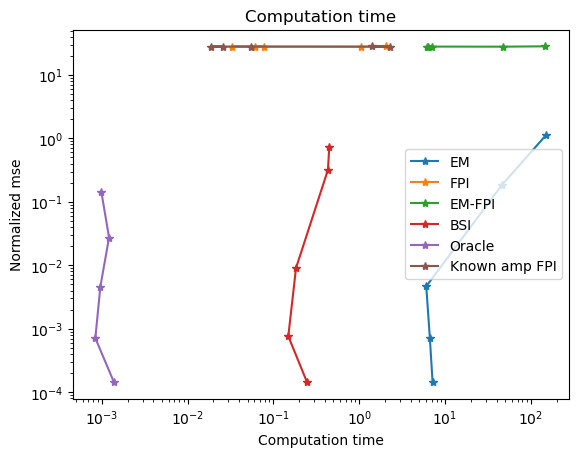

In [2]:

import sys
root = '/home/emastr/github/multireference-alignment/'
from multiprocessing import Pool
from alignment_vmap import *
import numpy as np
from numpy.fft import fft, ifft

import jax
import time
from jax import vmap, grad, jit, random, lax
from jax import numpy as jnp
from jax.numpy.fft import fft as jfft, ifft as jifft
from util.logger import EventTracker
import matplotlib.pyplot as plt
from alignment_vmap import em_method, fix_point_iter, align_average, autocorr_fft, loss_fft
from alignment_vmap import align_average_and_project, align, invariants_from_data, bispectrum_inversion
from itertools import product

def get_signal(L):
    ## GENERATE SIGNAL
    t = jnp.linspace(0, 2*np.pi, L+1)[:-1]
    #x = jnp.sin(t)
    x = (t < np.pi).astype(float)
    #x = np.random.randn(L)
    return t, x


def get_samples(key, x, noise_std, N):
    L = len(x)
    shiftkey, noisekey = jax.random.split(key, 2)
    shift = jax.random.randint(shiftkey, (N,), 0, L)
    noise = jax.random.normal(noisekey, (N, L)) * noise_std
    y = vmap(lambda s, z: jnp.roll(x + z, s), in_axes=(0, 0))(shift, noise)
    return y, noise, shift

def get_mse(x, y):
    return jnp.mean((x - y) ** 2)

def get_snr(x, noise_std):
    return get_mse(x, jnp.mean(x)) / noise_std ** 2

def get_rel_mse(x, y):
    return get_mse(x, y) / get_mse(x, 0.0)

def get_mean_centered_rel_mse(x, y):
    return get_mse(x, y) / get_mse(x, jnp.mean(x))

def get_aligned_rel_mse(x, y):
    y_al = align(jfft(x), jfft(y), y)
    return get_rel_mse(x, y_al) ** 0.5

def em_run(x0, y, noise_std):
    return em_method(jfft(x0), y, noise_std, tol=1e-6, batch_niter=3000, full_niter=10000)

def fpi_run(x0, y, noise_std):
    N, L = y.shape
    yfft = jfft(y, axis=1)
    y_auto_fft = jnp.clip(jnp.mean(autocorr_fft(yfft), axis=0) - noise_std**2 * L, 0, None) # mean of autocorrelation
    y_mean = jnp.mean(yfft[:, 0])  # Mean of means

    
    iter_ = [0]
    def callback(x, res, it):
        iter_[0] = it
    res = ifft(fix_point_iter(jfft(x0), yfft, y_auto_fft, y_mean, alpha=1.0, tol=1e-6, maxiter=int(1e4), callback=callback)).real
    print(f"Converged in {iter_[0]} iterations")
    return res

def fpi_em_run(x0, y, noise_std):
    x = em_method(jfft(x0), y, noise_std, tol=1e-6, batch_niter=3000, full_niter=10000)
    N, L = y.shape
    yfft = jfft(y, axis=1)
    #y_auto_fft = jnp.clip(jnp.mean(autocorr_fft(yfft), axis=0) - noise_std**2 * L, 0, None) # mean of autocorrelation
    y_auto_fft = jnp.abs(fft(x)) ** 2
    y_mean = jnp.mean(yfft[:, 0])  # Mean of means
    return ifft(fix_point_iter(jfft(x), yfft, y_auto_fft, y_mean, alpha=1.0, tol=1e-6, maxiter=int(1e4))).real

def bsi_run(x0, y, noise_std):
    N, L = y.shape
    yfft = jfft(y, axis=1)
    y_mean, yc_auto_fft, B = invariants_from_data(y, noise_std)
    x, x2, _ = bispectrum_inversion(y_mean, yc_auto_fft, B, tol=1e-6, maxiter=(15, 500))
    if loss_fft(jfft(x), yfft) > loss_fft(jfft(x2), yfft):
        x = x2
    return x


def algn_run(x0, y, noise_std):
    return ifft(align_average(jfft(x0),  fft(y, axis=1))).real


def average_std(M):
    def decorator(func):
        def wrapper(key, *args, **kwargs):
            keys = random.split(key, M)
            vals = jnp.array([func(keys[m], *args, **kwargs) for m in range(M)])
            return {"mean": jnp.mean(vals, axis=0), "std": jnp.std(vals, axis=0)}
        return wrapper
    return decorator

@average_std(3)
def run_methods(key, x, N, noise_std, methods):
    y, noise, shift = get_samples(key, x, noise_std, N)

    xfft = fft(x)
    x_auto_fft = jnp.abs(xfft)**2.

    
    # Add oracle - the other methods do not have access to the noise
    oracle = lambda x0, y, noise_std: x + jnp.mean(noise, axis=0)
    
    
    def oracle_fpi(x0, y, noise_std):
        yfft = jfft(y, axis=1)
        y_mean = jnp.mean(yfft[:, 0])  # Mean of means
        return  ifft(fix_point_iter(fft(x0), yfft, x_auto_fft, y_mean, alpha=1.0, tol=1e-20, maxiter=3000)).real

    methods = methods + (oracle, oracle_fpi)
    
    # Run methods
    def run(method):
        t = time.time()
        val = get_aligned_rel_mse(x, method(y[0, :].copy(), y, noise_std))
        t = time.time() - t
        return val, t
    return jnp.array([run(method) for method in methods])


# Main parameters
L = 41
N = int(1e4)
t, x = get_signal(L)

noise_stds = jnp.logspace(-2, 1., 5)
print(noise_stds)
keys = random.split(random.PRNGKey(0), len(noise_stds))

errs = []
for i, (ns, k) in enumerate(zip(noise_stds, keys)):
    print(f'RUN: std={ns}, total {i+1}/{len(noise_stds)} steps')
    errs.append(run_methods(k, x, N, ns, (em_run, fpi_run, fpi_em_run, bsi_run)))


#def f(x):
    #out = run_methods(x[0], x, N, x[1], (em_run, fpi_run))
    #print(f"Done with ns={x[1]}")
    #return out

#if __name__ == '__main__':
    #with Pool(10) as p:
        #errs = p.map(f, [(k, ns) for ns, k in zip(noise_stds, keys)])
    
#print(errs)

jnp.save(f'{root}data/alignment_methods.npy', errs)

# DATA: errs = {mean: method x (val, time), std: method x (val, time)}

means = jnp.array([e['mean'] for e in errs])
stds = jnp.array([e['std'] for e in errs])

print(stds.shape)


for j, name in enumerate(['Normalized MSE', 'Computation time']):
    fig = plt.figure()
    for i, method in enumerate(['EM', 'FPI', 'EM-FPI', 'BSI', 'Oracle', 'Known amp FPI']):
        plt.plot(noise_stds, means[:, i, j], '*-', label=method)
        plt.fill_between(noise_stds, means[:, i, j] - stds[:, i, j], means[:, i, j] + stds[:, i, j], alpha=0.3)
    plt.legend()
    plt.title(name)
    plt.ylabel(name)
    plt.xlabel("Noise level $\sigma$")
    plt.xscale('log')
    plt.yscale('log')
    fig.savefig(f"{root}data/plot_{j}.png", bbox_inches='tight')
    


fig = plt.figure()
for i, method in enumerate(['EM', 'FPI', 'EM-FPI', 'BSI', 'Oracle', 'Known amp FPI']):
    plt.plot(means[:, i, 1], means[:, i, 0], '*-', label=method)
    
plt.legend()
plt.title(name)
plt.ylabel(name)
plt.ylabel("Normalized mse")
plt.xlabel('Computation time')
plt.xscale('log')
plt.yscale('log')
fig.savefig(f"{root}data/plot_{3}.png", bbox_inches='tight')




# phase sync
# bispectrum in
# fix oracle bug (try true momets)
# sigma^6? (sigma,N)
# size=5
# numerical hessian estimate

#1) minisympo
#2) 29th april deadline posters 
#3) october conference

#1) genoa summer school 
# applied garmonic analysis ml

# sample complexity
# Check parallelism for models fft.
